### Анализ маркетинга в приложении Procrastinate Pro+:

Несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Требуется изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.
Данные будем смотреть от 1-го ноября 2019 года и в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.



1 Проведем исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?.

2 Маркетинг<br>
Выясним:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

3 Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI проанализируем:
- общую окупаемость рекламы;
- окупаемость рекламы с разбивкой по устройствам;
- окупаемость рекламы с разбивкой по странам;
- окупаемость рекламы с разбивкой по рекламным каналам.

Ответем на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Дадим рекомендации для рекламного отдела. 


#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Подготовка данные


In [1]:
#библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [2]:
try:
    users, purchase, promotion = (pd.read_csv('visits_info_short.csv'),
         pd.read_csv('orders_info_short.csv'),
         pd.read_csv('costs_info_short.csv'))
except:
    users, purchase, promotion = (pd.read_csv('/datasets/visits_info_short.csv'),
         pd.read_csv('/datasets/orders_info_short.csv'),
         pd.read_csv('/datasets/costs_info_short.csv'))

In [3]:
#посмотрим типы данных
display(users.info())
display()
display(purchase.info())
display()
promotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


В названиях колонок видны два нарушения стиля:
- Строчные буквы сочетаются с прописными.
- Не используется принцип змеиного регистра.

Нужно преобразовать данные о времени. 

In [4]:
users = users.rename(columns={'User Id':'user_id', 'Region':'region', 'Device':'device', 'Channel':'channel', 'Session Start':'session_start', 'Session End':'session_end'})

purchase = purchase.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'})

promotion = promotion.rename(columns={'dt':'dt', 'Channel':'channel', 'costs':'costs'})


In [5]:
users['session_start'] = pd.to_datetime(users['session_start'])
users['session_end'] = pd.to_datetime(users['session_end'])
purchase['event_dt'] = pd.to_datetime(purchase['event_dt'])
promotion['dt'] = pd.to_datetime(promotion['dt']).dt.date

In [6]:
#проверка на дубликаты
display(users.duplicated().sum())
display(purchase.duplicated().sum())
promotion.duplicated().sum()

0

0

0

In [7]:
display(round((users.isna().mean()*100),2))
display(round((purchase.isna().mean()*100),2))
round((promotion.isna().mean()*100),2)

user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

dt         0.0
channel    0.0
costs      0.0
dtype: float64

### Вывод

Проверила и подготовила данные для дальнейшего использования. Дубликатов и пропусков обнаружено не было. Тип всех дат были приведены к дате. Наименование колонок исправила два нарушения, что облегчит работату в дальнейшем. 

# Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии


In [8]:
#зададим момент анализа и горизонт анализа
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [9]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
#    for event in event_names:
#        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
#            profiles[event] = profiles['user_id'].isin(
#                events.query('event_name == @event')['user_id'].unique()
#            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(
        0
    )
    
    return profiles  # возвращаем профили с CAC

функция get_retention возвращает три результата:
сырые данные для отладки — retention_raw,
таблицу удержания — retention,
таблицу динамики удержания — retention_history

In [10]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [13]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


In [16]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

# Шаг 3. Исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.


In [17]:
profiles = get_profiles(users, purchase, promotion)
profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


In [18]:
display('минимальный день привлечения клиентов', profiles['first_ts'].min())
display('максимальный день привлечения клиентов', profiles['first_ts'].max())

'минимальный день привлечения клиентов'

Timestamp('2019-05-01 00:00:41')

'максимальный день привлечения клиентов'

Timestamp('2019-10-27 23:59:04')

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?


In [19]:
profiles_country = profiles.groupby('region').agg({'user_id':'nunique','payer':'sum'})
profiles_country['%'] = round(profiles_country['payer']/profiles_country['user_id']*100, 2)
profiles_country.sort_values(by='%', ascending=False)

,user_id,payer,%
region,,,
United States,100002,6902,6.90
Germany,14981,616,4.11
UK,17575,700,3.98
France,17450,663,3.80



- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?

In [20]:
profiles_device = profiles.groupby('device').agg({'user_id':'count','payer':'sum'})
profiles_device['%'] = round(profiles_device['payer']/profiles_device['user_id']*100, 2)
profiles_device.sort_values(by='%', ascending=False)

,user_id,payer,%
device,,,
Mac,30042,1912,6.36
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05


- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?


In [21]:
profiles_channel = profiles.groupby('channel').agg({'user_id':'count','payer':'sum'})
profiles_channel['%'] = round(profiles_channel['payer']/profiles_channel['user_id']*100, 2)
profiles_channel.sort_values(by='%', ascending=False)

,user_id,payer,%
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


Больше всего посетителей приходит из США. И оттуда их приходит больше, чем в пять раз чем из следующей страны - Великобритании. На третьем и четвертом месте Франция и Германия соответсвенно.
Если смотреть по количеству платящих пользователей, то рейтинг сохраниться. Но если смотреть сколько в процентном соотношении от всех пришедших пользователей, стали платящими пользователями, то рейтинг меняется: 
- на первом месте остается США
- на втором месте Германия
- на третьем Великобритания
- на четвертом Франция

Самое популярное устройство, которым пользуются посетители приложения, это iPhone. Почти в полтора раза меньше приходят с Android и это второе место. Еще меньше приходят с PC. Меньше всего пользователей с Мас. 
По количеству платящих посетителей рейтинг немного меняется. Первые два места  также занимают iPhone и Android соответственно. А на третьем место поднимается Мас.
Однако, если смотреть в процентном соотношение, то картина совсем другая. На первом месте Мас, на втором iPhone, на третьем Android и на последнем PC. Обладатели яблочной продукции охотнее становятся покупателями)

Наибольшее количество приходит с органического поиска. Из поисковой системы приходит почти в два раза больше людей, чем со стоящего на втором месте FaceBoom. На третьем месте TipTop. Если смотреть по количеству платящих пользователей, то на первом месте посетители с канала FaceBoom, на втором с TipTop, а на третьем с органического поиска. Однако, ести смотреть в процентом соотношении, то можно увидеть, что посетители из органического поиска соовсем не торопятся совершать покупки: они занимают последнее место и это всего 2%. Первое место у FaceBoom с очень хорошим процентом 12, на втором AdNonSense с 11%. На третьем месте с 10% - lambdaMediaAds. Хотя в количественном выражении второй и третий канал привели в покупатели всего 665 человек. С органического поиска 2% составляют почти в два раза больше покупателей: 1160человек.

Исходя из полученных данных, можно порекомендовать работать с каналами FaceBoom и TipTop. Ну и конечно не опускаться в поисковике и входит в топ-5.

Также обратить внимание на мобильную версию приложения, чтобы она работала без нареканий. Так как 60% посетителей приходят с мобильных телефонов. И Оттуда же приходит наибольшее количество платящих пользователей.


# Шаг 4. Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [22]:
'Всего потрачено',round(promotion['costs'].sum(),2)

('Всего потрачено', 105497.3)

In [23]:
promotion_channel = promotion.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
display('Потраченный бюджет в разрезе источников')
promotion_channel

'Потраченный бюджет в разрезе источников'

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


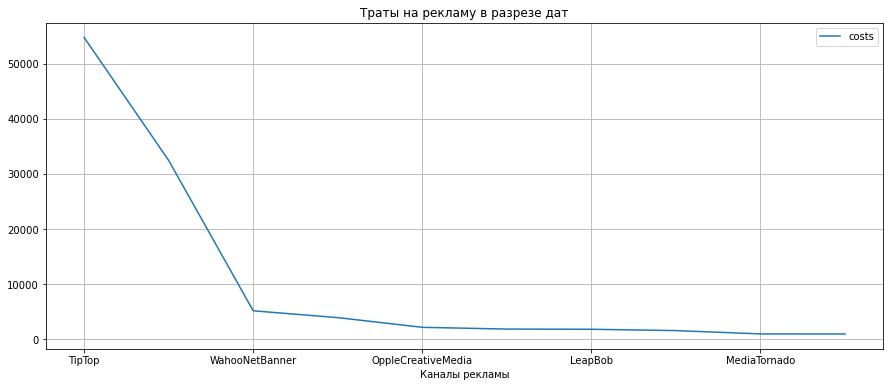

In [24]:
promotion_channel.plot(grid=True, figsize=(15,6))
plt.xlabel('Каналы рекламы')
plt.title('Траты на рекламу в разрезе дат')
plt.show()

In [25]:
promotion_dt = promotion.groupby('dt').agg({'costs':'sum'})
display('Потраченный бюджет в разрезе дат')
promotion_dt

'Потраченный бюджет в разрезе дат'

,costs
dt,
2019-05-01,304.820
2019-05-02,230.845
2019-05-03,263.070
2019-05-04,337.000
2019-05-05,319.905
...,...
2019-10-23,592.995
2019-10-24,737.590
2019-10-25,862.600


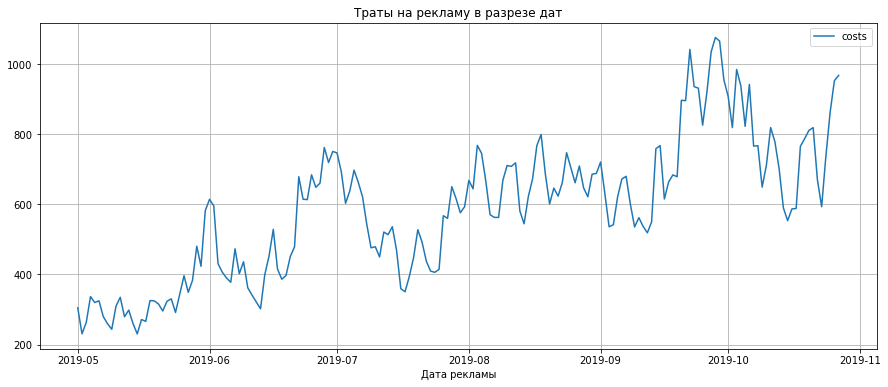

In [26]:
promotion_dt.plot(grid=True, figsize=(15,6))
plt.xlabel('Дата рекламы')
plt.title('Траты на рекламу в разрезе дат')
plt.show()

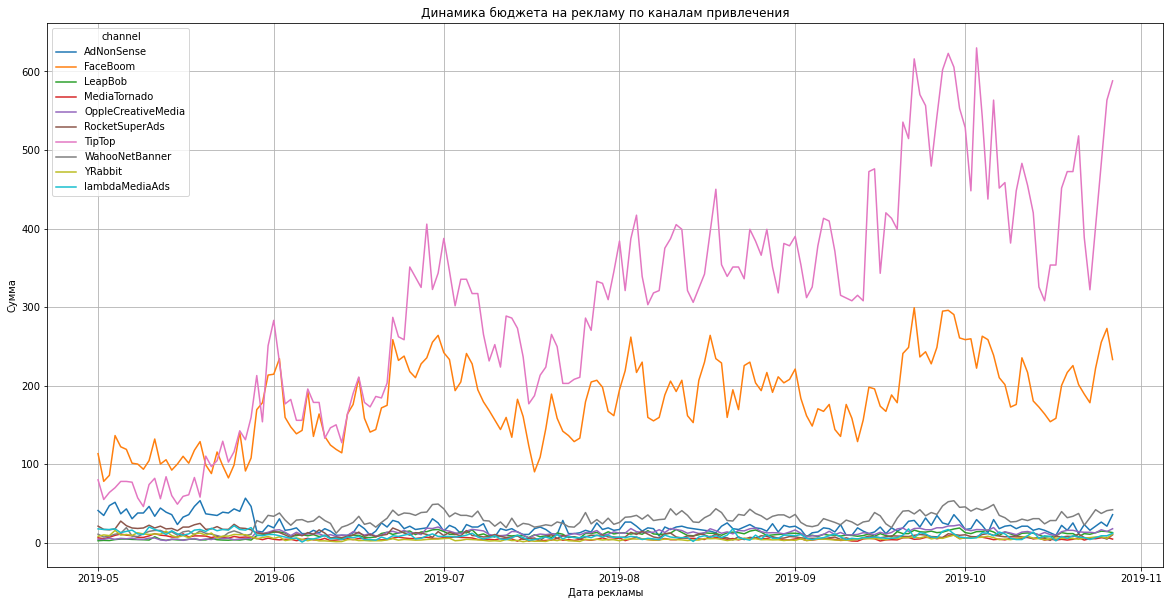

In [27]:
promotion.pivot_table(
    index='dt', columns='channel', values='costs', aggfunc='mean'
).plot(grid=True, figsize=(20, 10))
plt.ylabel('Сумма')
plt.xlabel('Дата рекламы')
plt.title('Динамика бюджета на рекламу по каналам привлечения')
plt.show()

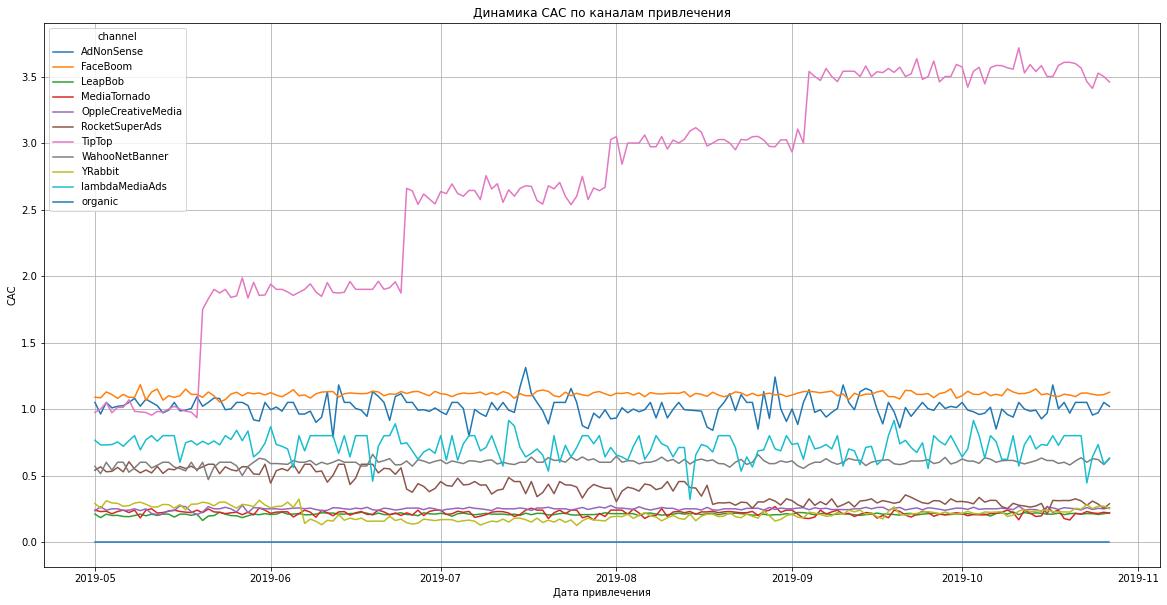

In [28]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(20, 10))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

In [29]:
profiles = profiles.query('channel != "organic"')

display('Средний САС для всего проекта', profiles['acquisition_cost'].mean())

'Средний САС для всего проекта'

1.127481323942928

In [30]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values('acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


За весь период на рекламу было потрачено 105497.3 денежных единиц. Больше всего потратила на рекламу в сети TipTop, почти половину бюджета! Одну треть бюджета потратила на рекламу в сети FaceBoom. На другие источники было потрачено гораздо меньше.

Если посмотреть на распределения бюджета по датам, то заметим, что есть тенденция на рост бюджета с каждым днем.
Самая дорогая стоимость получалась в начале месяца, а самая низкая в середине месяца. Стоимость в середине месяца практически в дав раза ниже, чем в начале. 

А вот если посмотреть в разрезе источников по стоимости привлечения одного клиента, то тут видно, что стоимость в сети TipTop ежемесячно растет и за весь период выроста в 3.5 раза! В остальных источниках стоимость практически не меняется. А у RocketSuperAds даже снизилась.
Средний САС на одного пользователя показывает, что самые дорогие приходят из сети TipTop. Это же видно и на графике. Примерно одинаковый средний САС у FaceBoom и AdNonSense.

Если вспомнить предыдущие выводы, то платящих покупателей с FaceBoom приходит в два раза больше, чем с TipTop. А на привлечение тратим на TipTop больше почти в 2.5 раза. Также на рекламу в AdNonSense тратим чуть меньше, чем на рекламу в FaceBoom, а людей оттуда приходит в 7.5 раз меньше. 

Возможно маркетологам надо пересмотреть распределение бюджета на рекламу между источниками.

Думаю, после проверки окупаемости, можно будет с увереностью это сказать.


# Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI проанализируем:
- общую окупаемость рекламы;
- окупаемость рекламы с разбивкой по устройствам;
- окупаемость рекламы с разбивкой по странам;
- окупаемость рекламы с разбивкой по рекламным каналам.


### Анализ общей окупаемость рекламы

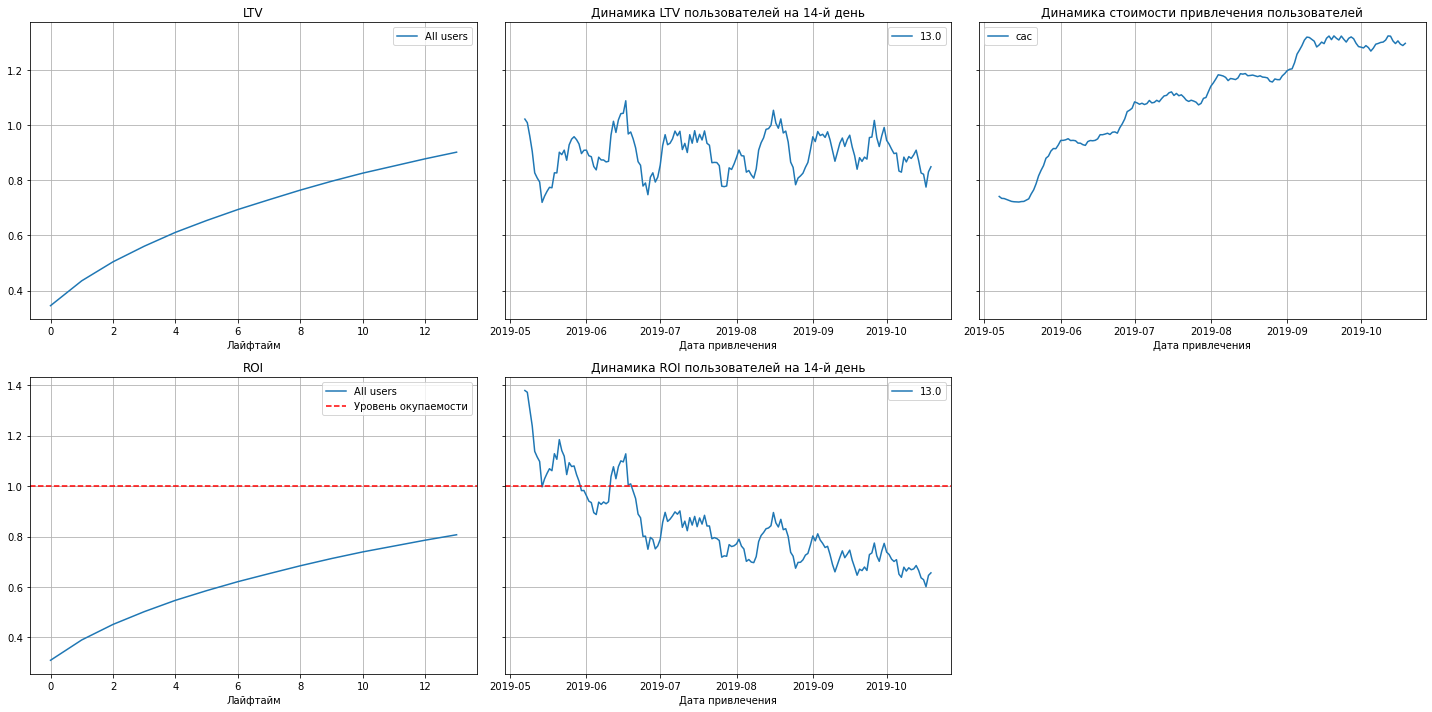

In [31]:
profiles = profiles.query('channel != "organic"')

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, purchase, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:<br>
Реклама не окупается. ROI в конце двух недель — 80%.<br>
CAC не стабилен. Вырос за рассматриваемый период почти в 2 раза.<br>
На LTV влияет сезонный фактор, но этот показатель достаточно стабилен.<br>
Из-за роста САС ROI в поздних когортах снижается и становится ниже уровня окупаемости, всего примерно 60%.

### Анализ окупаемости рекламы с разбивкой по устройствам

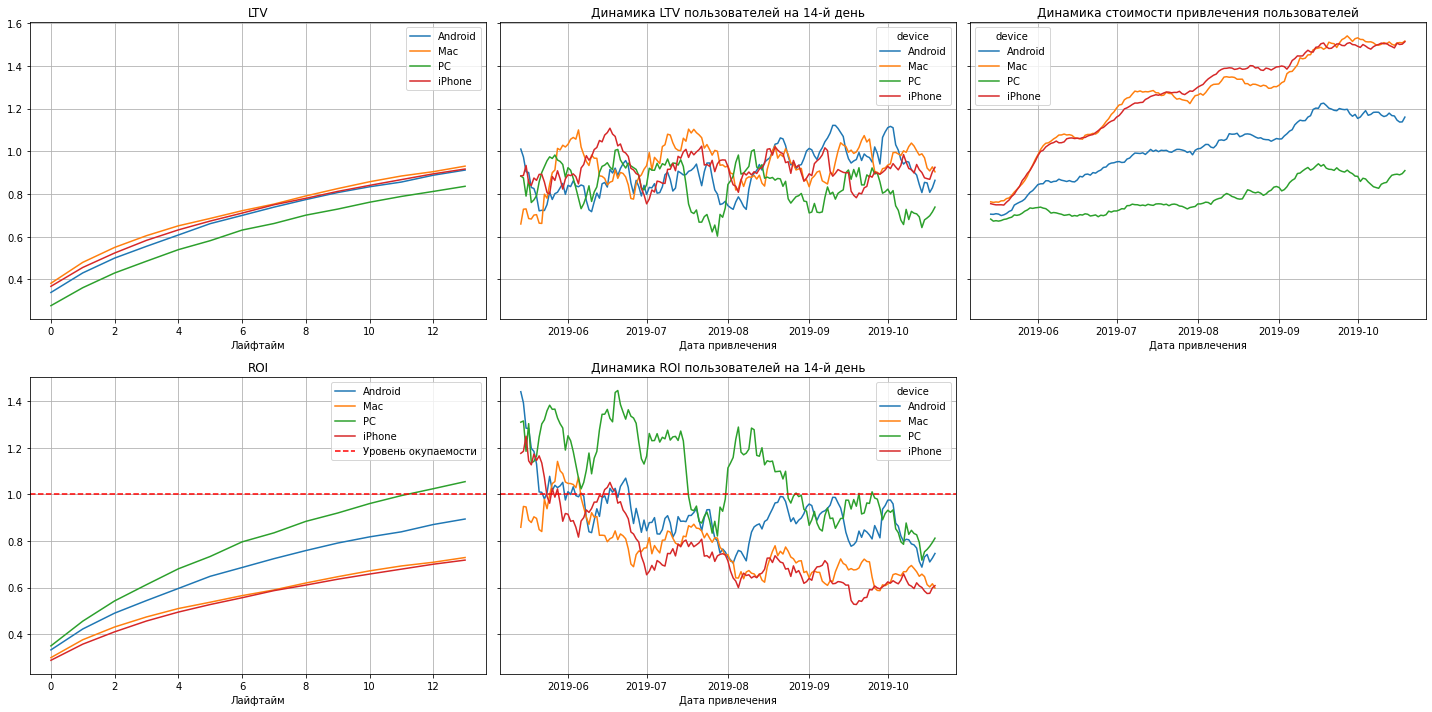

In [32]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, purchase, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Как и писала раньше, владельцы яблочной продукции больше тратят в приложении денег, а меньше всего тратят те, кто заходит с РС. Если смотреть по динамике пользователей на 14 день, то видно, что владельцы iPhone стали меньше оставлять денег. У остальных пользователей присутствует некакая цикличность, но все остается примерно на одном уровне.

Как мы видем на графике, стоимость привлечения покупателей на всех устройствах выросла в течении года. Но реклама на яблочных устройствах вырасла значительно, в три раза. На Android в 2.5 раза, на РС чуть больше, чем в два раза.

И из-за высокого CAC, привлечение клиентов на яблочных устройствах не окупается. Быстрее всего окупается для пользователей РС, уже на шестой день. Для пользователей устройств Android окупание происходит на 10 день.

Если смотреть в динамике, то можно увидеть что на момент горизонта, привлечение окупается только у РС. Все остальные перестали окупаться: на яблочной продукция примерно с конца июня, для Android был провальным месяц конец июля-начало августа, потом вроде пошло на рост, но с середины сентября окупаемость была все время колебалась.  

### Анализ окупаемости рекламы с разбивкой по странам

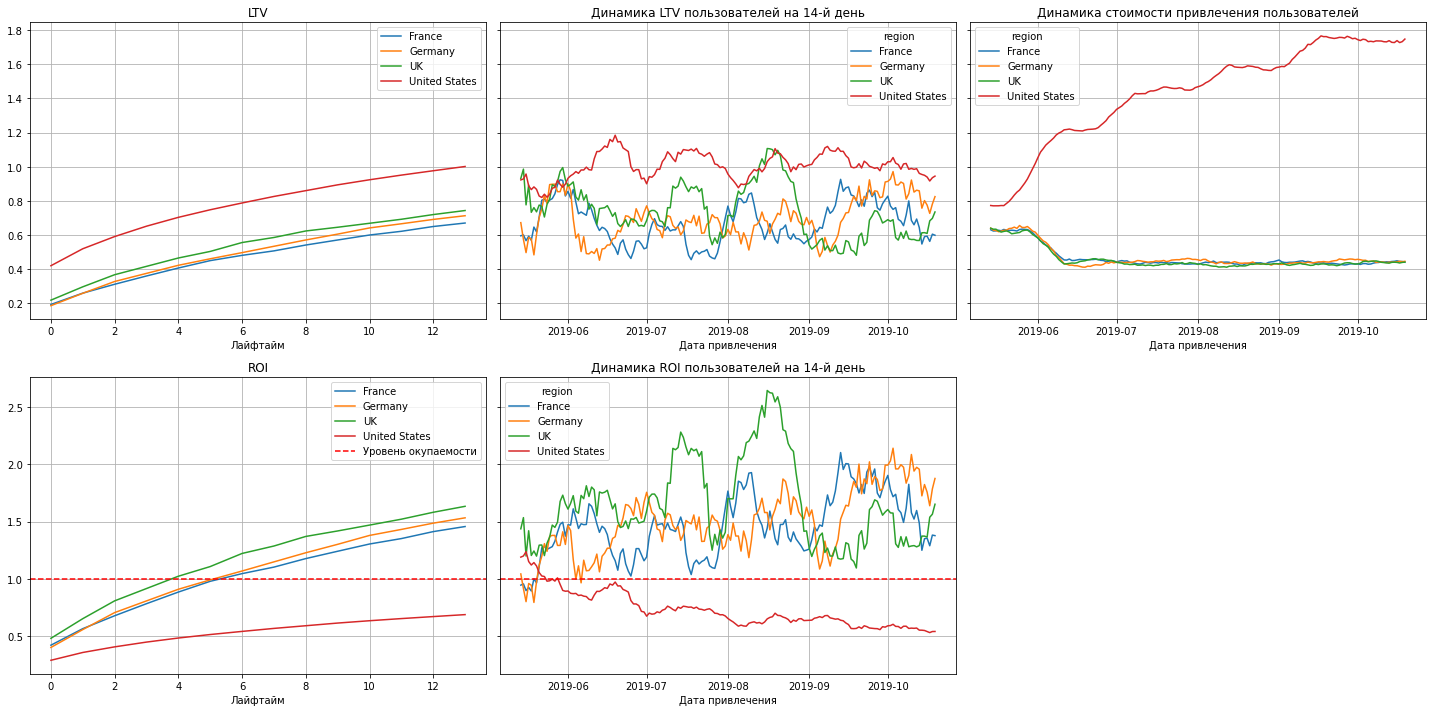

In [33]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, purchase, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

И опять похожая ситуация: больше всех тратят жители США, но у них самая дорогая стоимость привлечения клиента, и из-за этого реклама в этом регионе не окупается. 

В июне резко вырос САС в США, сначала почти в два раза, в последствии еще в полтора раза. И с этого момента реклама перестала себя окупать в данном регионе.

Во всех остальных регионах САС оставался стабилен и в любой период продвижение себя окупало примерно со второго-третьего дня. 

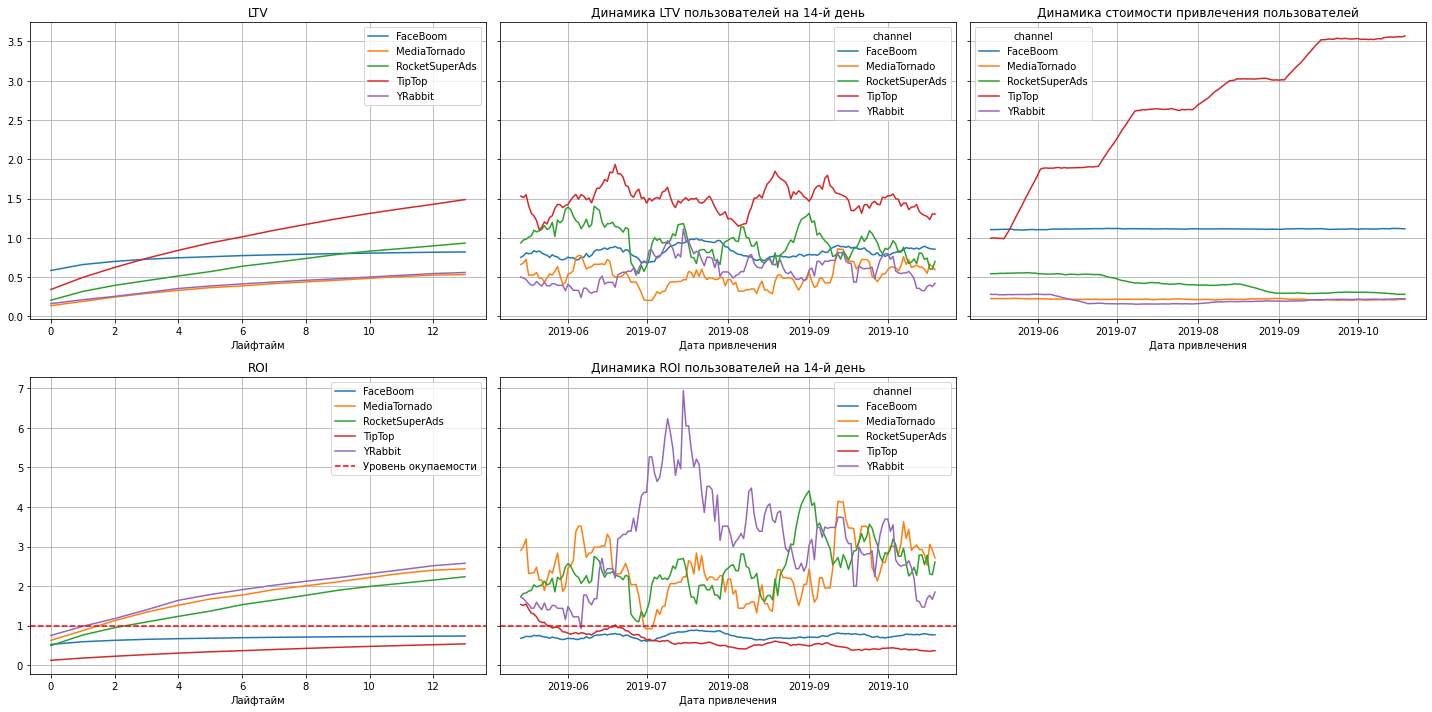

,user_id,%
channel,,
FaceBoom,29144,47.136457
MediaTornado,4364,7.058177
RocketSuperAds,4448,7.194035
TipTop,19561,31.637258
YRabbit,4312,6.974074


In [34]:
profiles_usa = profiles.query('region == "United States"')
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, purchase, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

plofiles_usa_q = profiles_usa.query('channel != "organic"').groupby('channel').agg({'user_id':'count'})

plofiles_usa_q['user_id'].count()

plofiles_usa_q['%'] = (plofiles_usa_q['user_id'])/plofiles_usa_q['user_id'].sum()*100
plofiles_usa_q


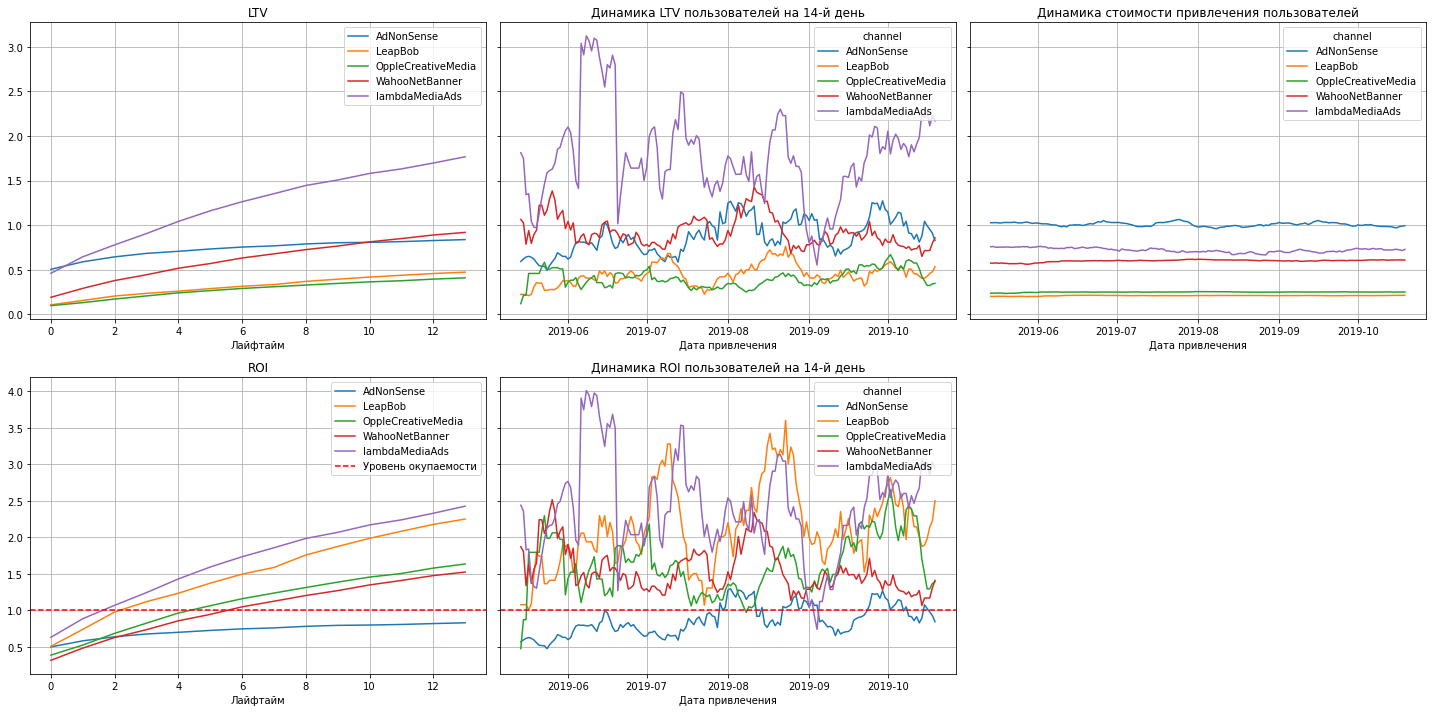

In [35]:
profiles_usa = profiles.query('region != "United States"')
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, purchase, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

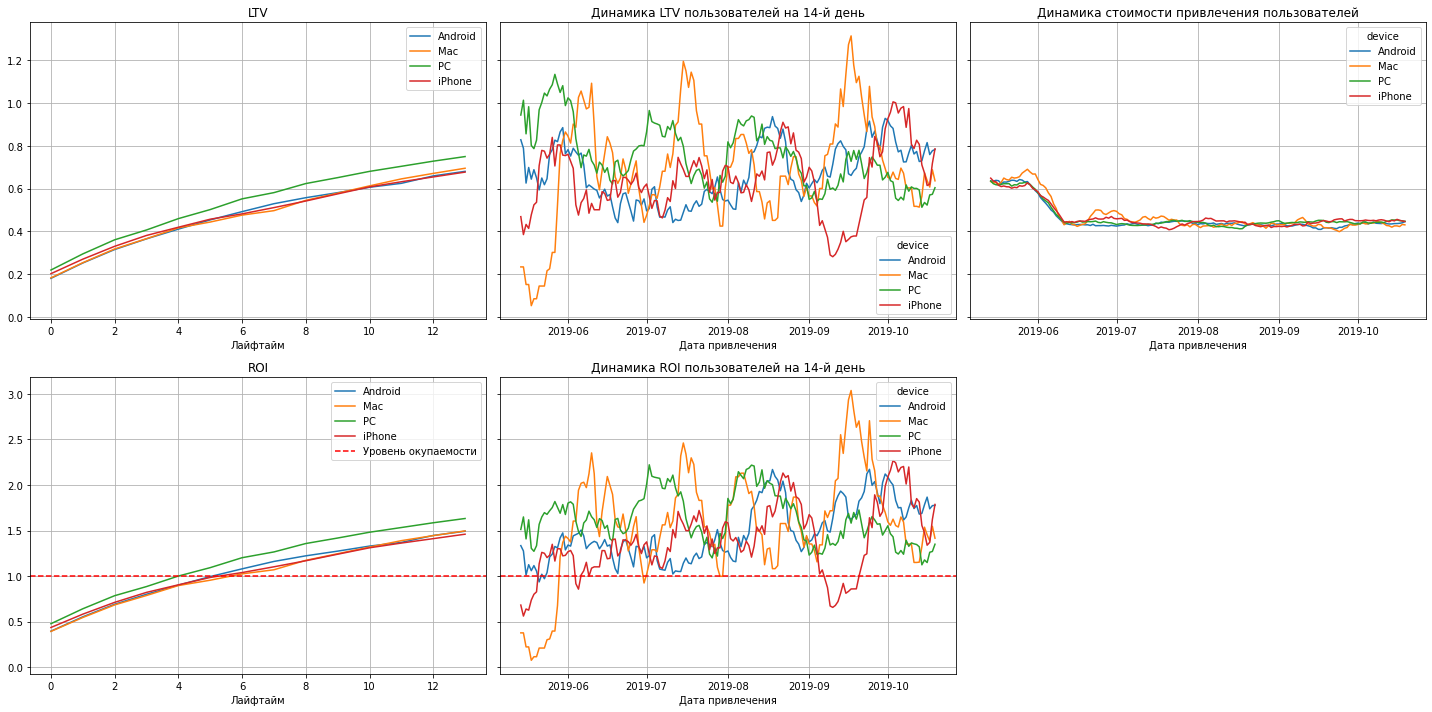

In [36]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, purchase, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Посмотрели на рекламу в США подробнее: 
- почти 79% пришли из FaceBoom и TipTop. У обоих каналов реклама не окупается. У TipTop - высокий САС, а  FaceBoom какая-то проблема с удержанием.
- остальные каналы окупаются, но с них идет мало народу. Возможно надо увеличить в этих каналах рекламу. Особо стоить обратить внимание на YRabbit: высокий ROI был летом, возможно если увеличить бюджет, получится снова увеличить ROI.
- в разрезе устройств все плохо: ни на одном устройстве реклама не окупается из-за высокого САС. 

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

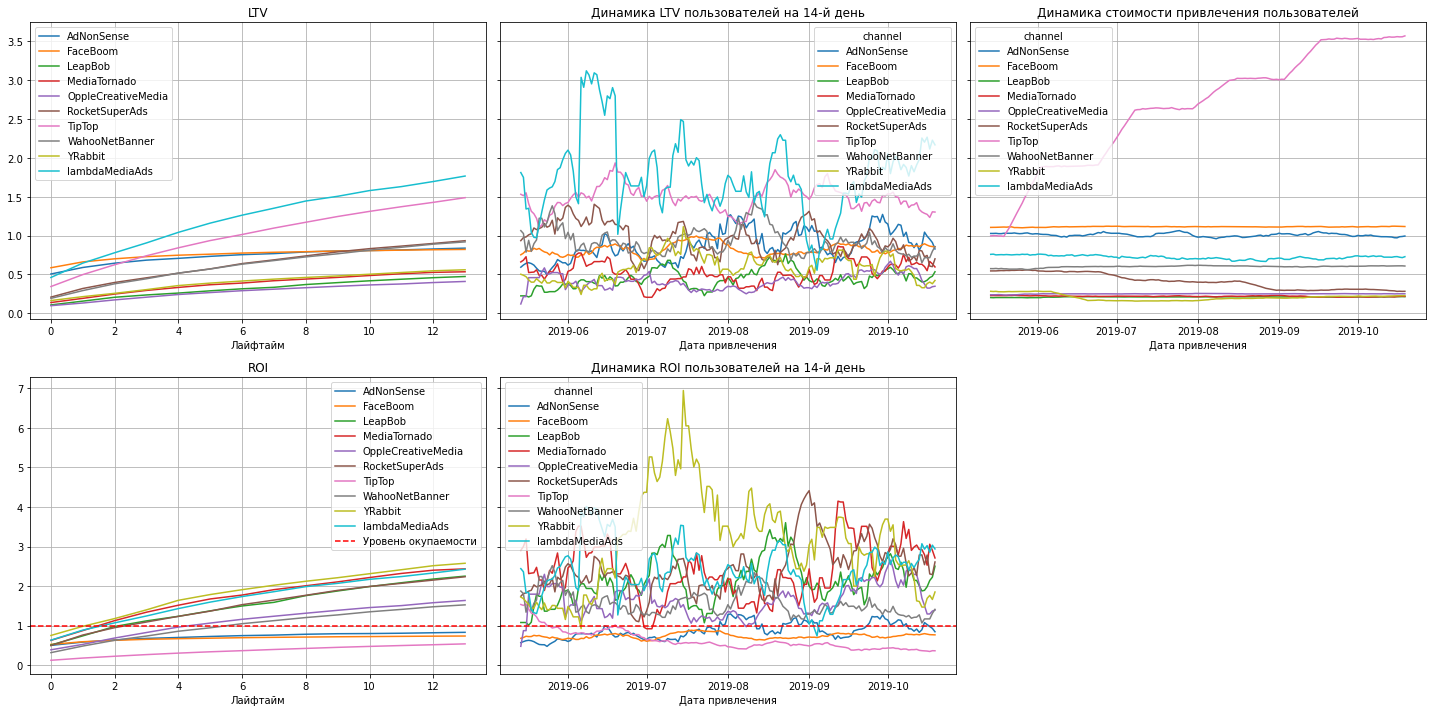

In [37]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, purchase, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

И здесь похожая ситуация) Самые "ценные" покупатели приходят из lambdaMediaAds и TipTop. lambdaMediaAds стабилен в стоимости привлечения, в окупаемости, но оттуда приходят не очень много людей, как мы видели в данных выше. А вот из TipTop приходит много покупателей, но стоимость их привлечения вырасла в 3.5 раза и реклама перестала себя окупать. Кроме этого не окупают себя и FaceBoom, и AdNonSense. Почему они не окупаются не очень понятно.

Почему не окупается привлечение на яблочных устройствах, понятно: высокий САС.
Почему не окупается реклама в США, тоже понятно: высокий САС.
Почему не окупается реклама в TipTop тоже понятно: опять высокий САС.

А вот почему не окупается в сети FaceBoom, не понято. Для этого посмотрим конверсию и удержание в разрезе каналов. 

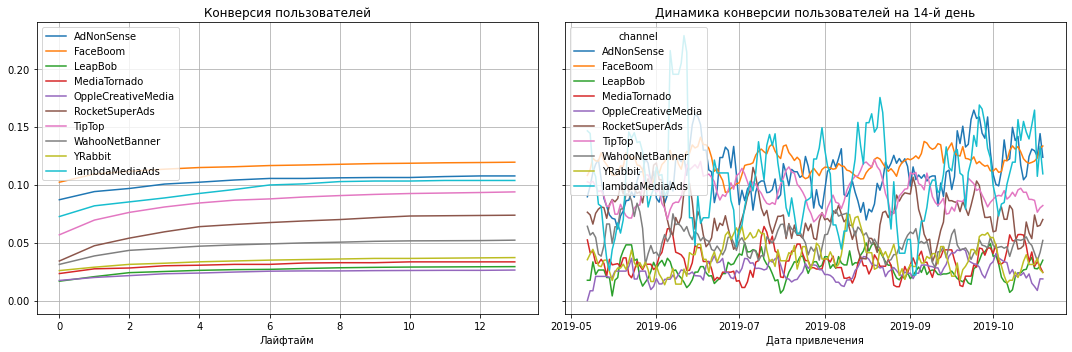

In [38]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, purchase, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, покупатели из канала FaceBoom конвертируются очень хорошо, причём постоянно. 

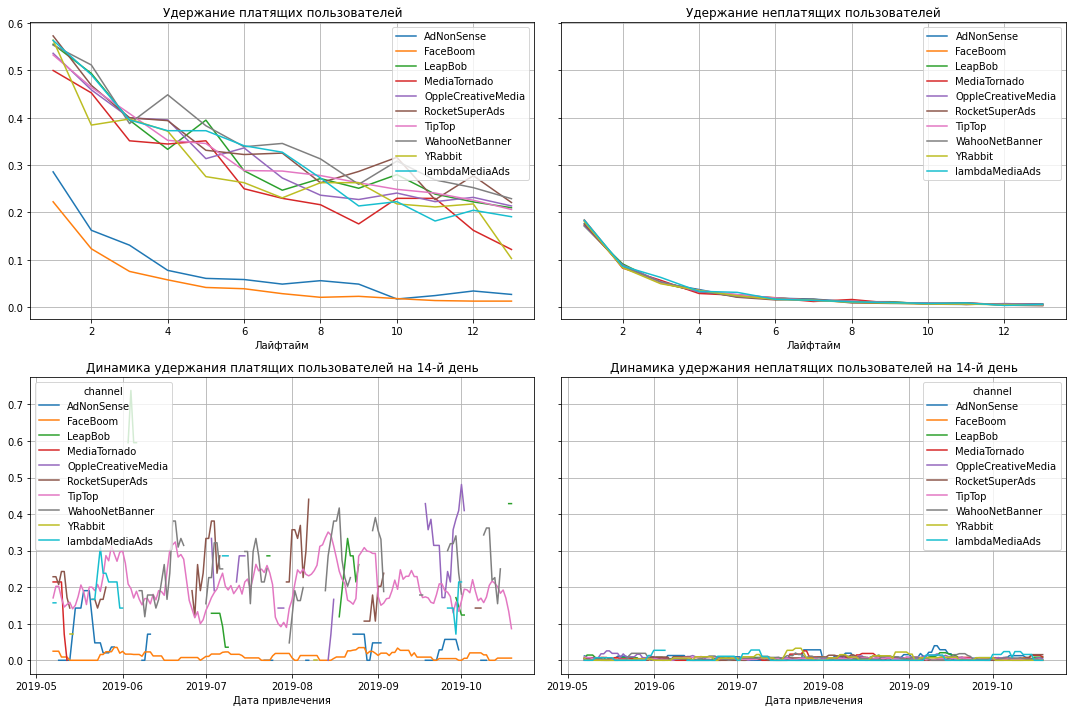

In [39]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, users, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Действительно, покупатели с FaceBoom стабильно плохо удерживаются. Для платящих пользователей с канала FaceBoom удержание 14-го дня ниже около 2-3%, для остальных каналов это примерно 25-30%. Это очень низкий показатель.
Скорее всего, причина в какой-нибудь технической проблеме.

Построим графики конверсии и удержания с разбивкой по устройствам

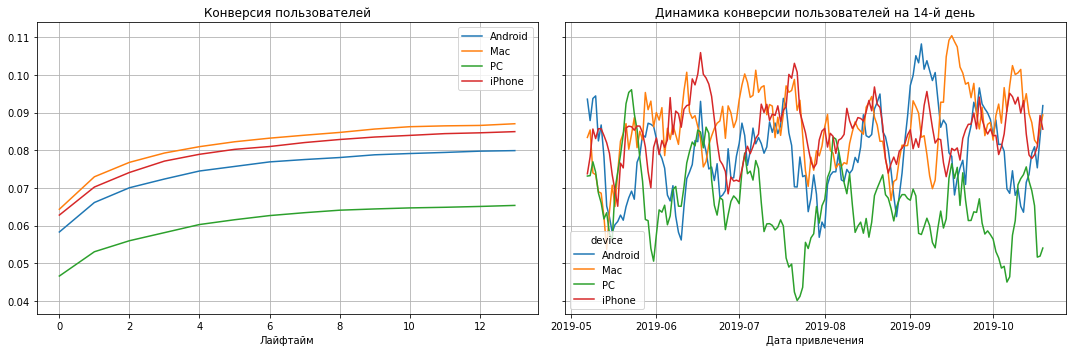

In [40]:
dimensions = ['device']

# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, purchase, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)


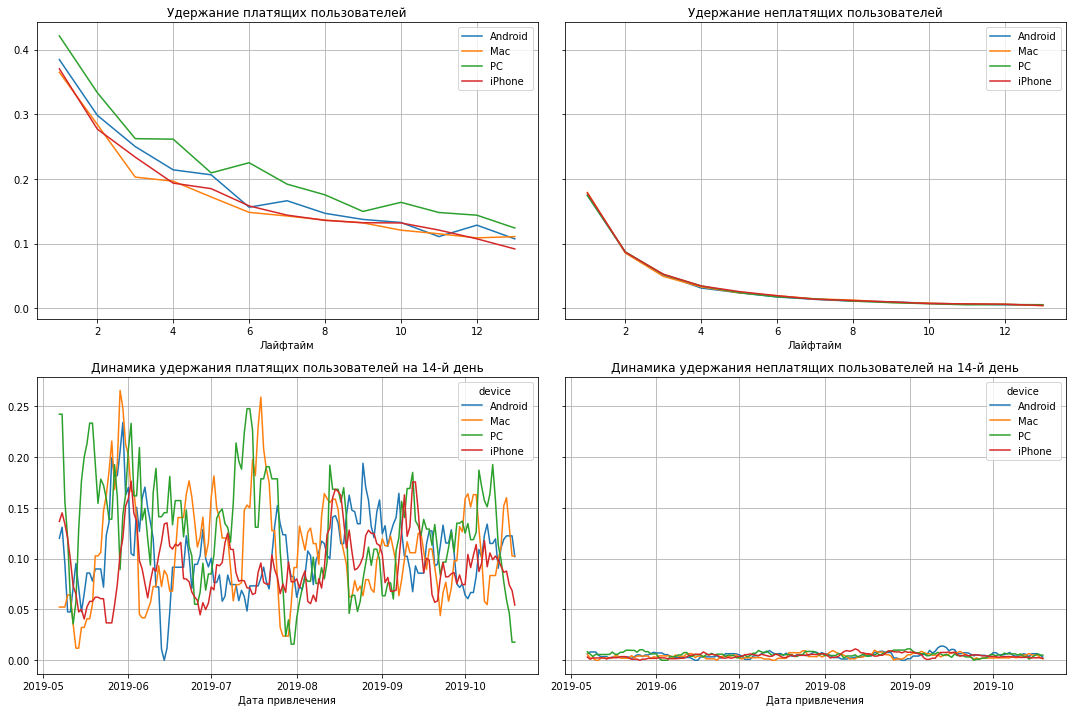

In [41]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, users, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Как видно из графиков конверсия на всех устройствах хорошая и как мы уже писали выше, лучшая конверсия на яблочных устройствах. А вот удержание платящих пользоватлей с точностью наоборот: лидируют владельцы РС, владельцы яблочной продукции быстрее отваливаются и невозвращаются за повторными покупками.Это же видно и на графике динамики удержания платящих пользователей на 14 день.

Построим графики конверсии и удержания с разбивкой по странам

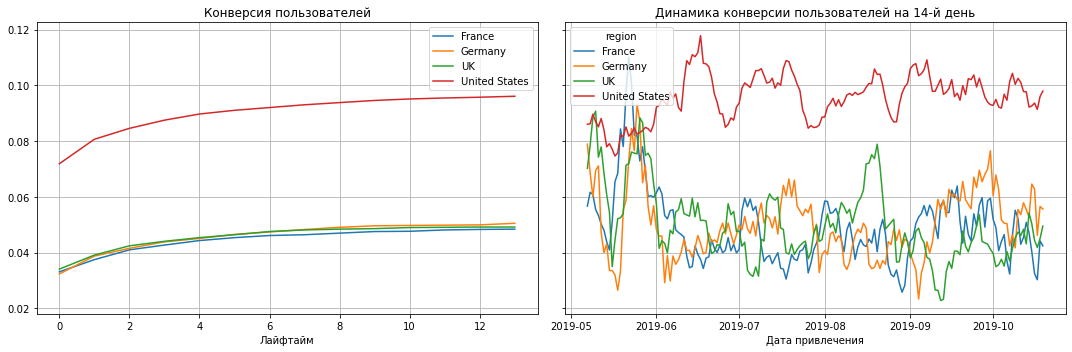

In [42]:
dimensions = ['region']

# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, purchase, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

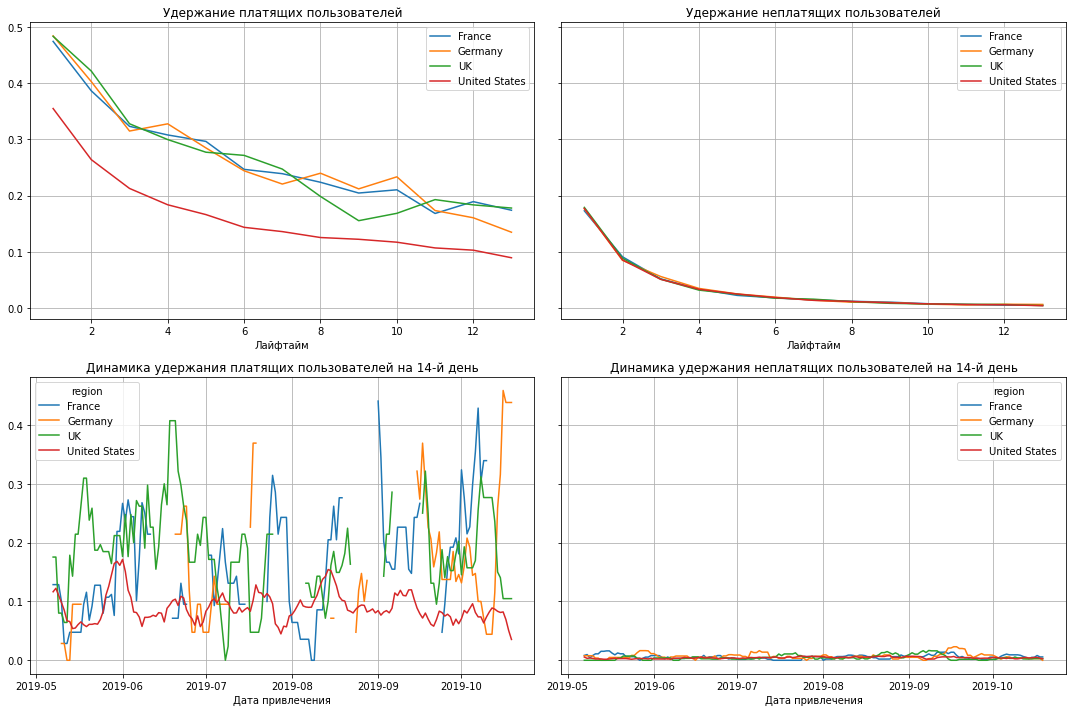

In [43]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, users, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Из графиков видно, что самая высокая конверсия среди пользователей из США. Почти в 2.5 раза больше, чем из других стран. Из других стран конверсия примерно одинаковая. Тоже наблюдаем и на динамике конверсии на 14 день.

А вот удержание опять с точность наоборот: самая низкая у США. В остальных странах опять примерно одинаковая.

### Вывод

Проанализировав все данные, можно заметить, что из-за высокой стоимости привлечения в США, привлечение себя не окупает.
Таже ситуация с пользователя продукции Apple и Mac. Из-за высокого САС реклама не окупается на этих устройствах.
По каналам привлечения есть четкое понимание, что высокая цена САС в TipTop, сводит все усилия маркетинга к нулю.
А вот с низким удержание по каналу FaceBoom и AdNonSense надо разбираться. Для этого нужны дополнительные данные. Скорее всего, причина в какой-нибудь технической проблеме.



# Шаг 6. Выводы


Проанализировав данные, стало понятно, что в разрезе стран продвижение неэффективно в США, в разрезе устройств не эффективно на яблочных устройствах (Apple и Mac), в разрезе каналов не эффективна в TipTop. С каналом  FaceBoom надо разбираться, скорее всего причина в технической ошибке.

Складывается впечатление, что основные пользователи из США пользуются яблочными устройствами и приходят из сети TipTop))) 

В остальных странах привлечение себя окупает. Также и на других устройствах, реклама себя окупает.

Мои рекомендации для отдела маркетинга:
- разобраться почему такой низкий процент удержания из канала FaceBoom. Устранить данную проблему.
- найти другие способы продвижения в США, попытаться снизить САС. Если это не возможно, то перераспределить бюджет на другие страны, например Германию. В данной стране конверсия 4%, хорошая динамика удержания на 14 день.Окупаемость происходит уже на 2 день.
- подобная рекомендация будет и поканалу привлечения TipTop: либо найти способ снизить САС, либо перераспределить бюджет на более прибыльные каналы. 
Самые "ценные" покупатели, у которых высокий LTV, пришли из каналов TipTop и AdNonSense. По TipTop уже дала рекомендации. А вот к каналу AdNonSense стоит присмотреться. Там тоже присутствует проблема с удержанием, надо попробовать решить эту проблему, и если она решаема, но увеличить там продвижение.
Такая же рекомендация по каналу FaceBoom: выяснить причину низкого удержания и устранить. Бюджет либо оставить прежний, либо увеличить. 
И есть еще один канал, к которому надо присмотреться. Это YRabbit. У данного канала высок ROI и стабильно низкий САС. Там тоже есть проблема с удержанием, но скорее всего это связано с низким бюджетом продвижения. Его следует увеличить и посмотреть, что получится.

По США рекомендую обратить внимание на следующие каналы: RocketSuperAds, MediaTornado и YRabbit. Но надо будет следить, тк в разрезе устройств реклама в США не окупается совсем.


В Европе рекомендую развивать продвижение в каналах LeapBob и LambdaMediaAds.
